# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

/Users/lukedoolittle/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lukedoolittle/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

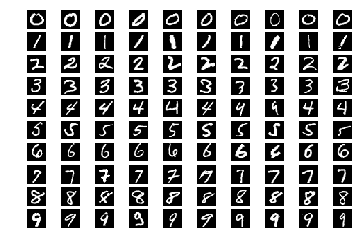

In [3]:
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28

class ImageSet:
    def __init__(
            self, 
            imageVector, 
            imageHeight = IMAGE_HEIGHT, 
            imageWidth = IMAGE_WIDTH):
        self._imageVector = imageVector
        self._imageHeight = imageHeight
        self._imageWidth = imageWidth
    
    def __getitem__(
            self, 
            key):
        # create a matrix of width and height by reshaping
        # the given vector of pixel values
        return self._imageVector[key, :].reshape((
            self._imageHeight, 
            self._imageWidth))

def P1(num_examples=10):
    f, subplots = plt.subplots(
        10, 
        num_examples)
    
    Images = ImageSet(train_data)
    
    for digit in range(10):
        # find indicies in training_labels for the current digit
        matchingLabels = [index 
                          for index in range(train_labels.size) 
                          if train_labels[index] == digit]
        
        for exampleNumber in range(num_examples):
            # for each example get the equivalent pixel matrix
            # and plot the grayscale bitmap
            subplots[digit, exampleNumber].axis('off')
            subplots[digit, exampleNumber].imshow(
                Images[matchingLabels[exampleNumber]], 
                cmap='gray')

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



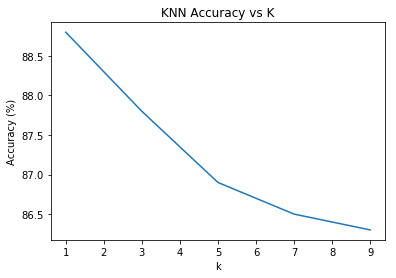

In [4]:
def P2(k_values):
    accuracies = []
    
    # fit and score a KNN classifier for each given
    # value of k
    for k in k_values:
        classifier = KNeighborsClassifier(k)
        classifier.fit(
            mini_train_data, 
            mini_train_labels) 
        accuracies.append(classifier.score(
            dev_data, 
            dev_labels) * 100.0)
    
    # plot the accuracies against the values of k
    plt.plot(k_values, accuracies)
    plt.title('KNN Accuracy vs K')
    plt.xlabel("k")
    plt.ylabel("Accuracy (%)")
    
    # fit and generate a classification report for
    # a KNN with k=1
    classifier = KNeighborsClassifier(1)
    classifier.fit(
        mini_train_data, 
        mini_train_labels) 
    devPredictions = classifier.predict(dev_data)
    print(classification_report(
        dev_labels, 
        devPredictions))

k_values = [1, 3, 5, 7, 9]
P2(k_values)

ANSWER: Going by the F1 score the digit "9" is the most difficult to predict

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

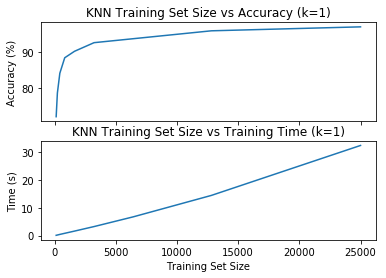

In [77]:
def P3(train_sizes, accuracies):
    trainingTimes = []
    classifier = KNeighborsClassifier(1)
    
    for trainSize in train_sizes:
        # take trainSize data from the train_data set and then
        # run the KNN evaluation function while
        # logging the begin and end time
        startTime = time.time()
        classifier.fit(
            train_data[:trainSize], 
            train_labels[:trainSize]) 
        accuracy = classifier.score(
            dev_data, 
            dev_labels) * 100.00
        endTime = time.time()
        
        accuracies.append(accuracy)
        trainingTimes.append((endTime - startTime))
    
    # plot training size versus accuracy and versus training time
    f, subplot = plt.subplots(2, sharex = True)
    
    subplot[0].plot(train_sizes, accuracies)
    subplot[0].set_title('KNN Training Set Size vs Accuracy (k=1)')
    subplot[0].set_ylabel('Accuracy (%)')
    
    subplot[1].plot(train_sizes, trainingTimes)
    subplot[1].set_title('KNN Training Set Size vs Training Time (k=1)')
    subplot[1].set_ylabel('Time (s)')
    subplot[1].set_xlabel('Training Set Size')
    
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [82]:
def sigmoid(x):
    return 100.0 / (1.0 + np.exp(-2.5 * x / 100.0))

def P4():
    # fit a "dumb" regression line to predict
    classifier = LinearRegression(fit_intercept=True)
    classifier.fit(
        np.transpose([train_sizes]), 
        accuracies) 
    prediction = classifier.predict(np.array([[60000]]))
    print('Predicted accuracy for 60000 training samples: {:.1f}%'
          .format(prediction[0]))
    
    # use a sigmoid transform on the training sizes before predicting
    classifier.fit(
        np.transpose([train_sizes]), 
        sigmoid(np.array(accuracies)))
    prediction = classifier.predict(np.array([[60000]]))
    print('Predicted accuracy for 60000 training samples with sigmoid transform: {:.1f}%'
          .format(prediction[0]))
P4()

Predicted accuracy for 60000 training samples: 124.3%
Predicted accuracy for 60000 training samples with sigmoid transform: 98.1%


ANSWER: It predicts 124% accuracy for 60000 training examples. Using linear regression is problematic here because, as we can see from the above plot, the relationship between training set size and accuracy is non linear. In general the relationship between a predictive model accuracy and training set size, according to the literature, is logarithmic. But we also know that, at a maximum the accuracy is 100% so we might try an inverse transform with an asymptote at 100% such as an adjusted sigmoid. This yields a predicted accuracy of ~98%.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Some examples of where a 4 was thought to be a 9 and vice versa


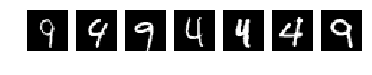

In [7]:
def P5():
    MAX_EXAMPLES = 7
    
    # make predictions with a KNN of k=1 and
    # create the confusion matrix
    classifier = KNeighborsClassifier(1)
    classifier.fit(            
            mini_train_data, 
            mini_train_labels)
    predictions = classifier.predict(dev_data)
    confusion = confusion_matrix(
            dev_labels, 
            predictions)
    
    # flip the confusion matrix to be upper triangular with nothing on the
    # diagonal to indicate "directionless" digit to digit classification
    # errors
    confusedPairs = np.triu(confusion) + np.transpose(np.tril(confusion))
    np.fill_diagonal(confusedPairs, 0)
    
    # find the indicies of the maximum value in the confusion matrix
    # to determine the most confused digit pairs then find the 
    # indicies of the errors in dev_labels
    digit1, digit2 = np.unravel_index(
        confusedPairs.argmax(), 
        confusedPairs.shape)
    errorsInDevPredictions = [i for i in range(dev_labels.size) 
            if (dev_labels[i] == digit1 and predictions[i] == digit2) or
               (dev_labels[i] == digit2 and predictions[i] == digit1)]
    
    # take a sample of the errors and plot them
    errorExamples = errorsInDevPredictions[:MAX_EXAMPLES]
    f, subplots = plt.subplots(
        1, 
        len(errorExamples))
    
    Images = ImageSet(dev_data)
    
    for errorNumber, error in enumerate(errorExamples):
        subplots[errorNumber].axis('off')
        subplots[errorNumber].imshow(
            Images[error],
            cmap='gray')

    print('Some examples of where a {0} was thought to be a {1} and vice versa'.format(
        digit1, 
        digit2))
P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [11]:
def boxBlur(
        target, 
        xSize = IMAGE_HEIGHT, 
        ySize = IMAGE_WIDTH, 
        neighborhood = 1):
    neighborCount = (2 * neighborhood + 1) ** 2
    
    # transform the array into a matrix of the given image dimension
    target = target.reshape(xSize, ySize)
    blurredTarget = np.zeros((xSize, ySize))
    
    # for each x,y coordinate the blurredTarget will be the sum of 
    # each neighbor, or 0 if outsize of the matrix dimensions, divided
    # by the neighborCount
    for y in range(ySize):
        for x in range(xSize):
            blurredTarget[x][y] = (np.sum(
                target[
                    max(x - neighborhood, 0) : min(x + neighborhood + 1, xSize), 
                    max(y - neighborhood, 0) : min(y + neighborhood + 1, ySize)]) 
                / neighborCount)
            
    return np.array(blurredTarget).flatten()

def P6(): 
    # create blurred training and dev data
    blurredTrainData = [boxBlur(mini_train_data[i, :]) 
                        for i in range(mini_train_data.shape[0])]
    
    blurredDevData = [boxBlur(dev_data[i, :]) 
                      for i in range(dev_data.shape[0])]
    
    # fit and score each combination of blurred and non-blurred
    # train and dev data
    classifier = KNeighborsClassifier(1)
    
    classifier.fit(
        mini_train_data, 
        mini_train_labels)
    accuracyNoBlur = classifier.score(
        dev_data,
        dev_labels)
    accuracyBlurDev = classifier.score(
        blurredDevData,
        dev_labels)  
    
    classifier.fit(
        blurredTrainData, 
        mini_train_labels)
    accuracyBlurTrain = classifier.score(
        dev_data,
        dev_labels)
    accuracyBlurTrainAndDev = classifier.score(
        blurredDevData,
        dev_labels) 
    
    print('Accuracy with no blurring: {:.1f}%'.format(accuracyNoBlur * 100.0))
    print('Accuracy with blurred training data only: {:.1f}%'.format(accuracyBlurTrain * 100.0))
    print('Accuracy with blurred dev data only: {:.1f}%'.format(accuracyBlurDev * 100.0))
    print('Accuracy with blurred training and dev data: {:.1f}%'.format(accuracyBlurTrainAndDev * 100.0))

P6()

Accuracy with no blurring: 88.8%
Accuracy with blurred training data only: 90.9%
Accuracy with blurred dev data only: 87.1%
Accuracy with blurred training and dev data: 90.3%


ANSWER: The key component is blurring the training data as that blur may help reduce variance.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [12]:
def P7():
    # fit and score a Bernoulli Naive Bayes with .5 as the binarization
    # cutoff
    classifier = BernoulliNB(binarize=0.5)
    classifier.fit(
        mini_train_data, 
        mini_train_labels)
    binaryAccuracy = classifier.score(
        dev_data,
        dev_labels)
    print('Binary Naive Bayes accuracy on dev data: {:.1f}%'.format(binaryAccuracy * 100.0))
    
    # fit and score a Multinomial Naive Bayes with 3 equally spaced buckets
    bins = np.array([1.0/3.0, 2.0/3.0, 1.0])
    
    classifier = MultinomialNB()
    classifier.fit(
        np.digitize(mini_train_data, bins), 
        mini_train_labels)
    multinomialAccuracy  = classifier.score(
        np.digitize(dev_data, bins),
        dev_labels)
    print('Multinomial Naive Bayes accuracy on dev data: {:.1f}%'.format(multinomialAccuracy * 100.0))

P7()

Binary Naive Bayes accuracy on dev data: 81.5%
Multinomial Naive Bayes accuracy on dev data: 80.1%


ANSWER: The result of the multinomial is about the same as for the binary. Given what we can deduce about the issues in the accuracy above (for example 4's interpreted as 9's has more to do with loops in the strokes) it is unlikely partitioning the parameters into 3 buckets instead of 2 will have much impact on the final result.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [8]:
def P8(alphas):
    # fit a Bernoulli Naive Bayes and use GridSearchCV to find the optimal
    # value of Alpha
    naiveBayesSearch = GridSearchCV(
        BernoulliNB(binarize=0.5), 
        alphas)
    naiveBayesSearch.fit(
        mini_train_data, 
        mini_train_labels)
    print('Best value of alpha:', naiveBayesSearch.best_params_['alpha'])
    print('Best score: {:.1f}%'.format(naiveBayesSearch.best_score_ * 100))
    print('Score w/ Alpha at 0: {:.1f}%'.format(naiveBayesSearch.grid_scores_[0][1] * 100))

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

/Users/lukedoolittle/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/lukedoolittle/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/lukedoolittle/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:820: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/lukedoolittle/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


Best value of alpha: 0.01
Best score: 82.1%
Score w/ Alpha at 0: 9.2%


In [9]:
# print(naiveBayesSearch.best_params_)

ANSWER: The best value of alpha is at .01 and gives a score of 82.1%. The score for alpha at 0 is only 9.2%. This actually isn't too surprising in general because NB with no smoothing and a smaller training set is known to have lower accuracy. In addition it appears that the sklearn NBBernoulli has some internal issues when alpha is set to zero, as indicated here https://github.com/scikit-learn/scikit-learn/issues/5814

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [6]:
def P9():
    # fit and score a Gaussian Naive Bayes
    classifier = GaussianNB()
    classifier.fit(
        mini_train_data, 
        mini_train_labels)
    accuracy = classifier.score(
        dev_data, 
        dev_labels)
    
    # now try to override the learned sigma,
    # setting it uniformally to 1
    classifier.sigma_ = np.ones(
        classifier.sigma_.shape)
    accuracyWithAdjustedSigma = classifier.score(
        dev_data, 
        dev_labels)
    
    return accuracy, accuracyWithAdjustedSigma

gnb, gnbMod = P9()
print('Accuracy of Gaussian Naive Bayes: {:.1f}%'.format(gnb * 100.0))
print('Accuracy of Gaussian Naive Bayes with adjusted sigma: {:.1f}%'.format(gnbMod * 100.00))

Accuracy of Gaussian Naive Bayes: 62.1%
Accuracy of Gaussian Naive Bayes with adjusted sigma: 80.2%


ANSWER: The accuracy of the Gaussian Naive Bayes is about 20% less than the Bernoulli Naive Bayes. The Gaussian Naive Bayes operates under the assumption that each individual parameter (in this case pixel) fits a normal distribution. However a particular digit being translated or rotated may cause a needlessly high variance in pixels within a single class. One solution would be to simply "flatten" out the variance across all classes by setting sigma to be 1 (the variance in a standard normal distribution). This produces an accuracy that is somewhat near that of the Bernoulli Naive Bayes.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

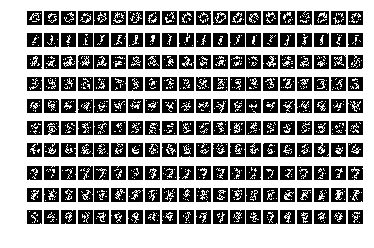

In [11]:
def P10(num_examples):
    f, subplots = plt.subplots(
        10, 
        num_examples)
    
    # fit a Bernoulli Naive Bayes on the mini_train_data
    # then extract the priors from the result
    classifier = BernoulliNB(binarize=0.5)
    classifier.fit(
            mini_train_data, 
            mini_train_labels)
    featureProbabilities = np.exp(
        classifier.feature_log_prob_)
    
    for digit in range(10):  
        for exampleNumber in range(num_examples):
            # create the image by pulling uniform random number on [0,1] that 
            # happen to be greater than the feature priors
            imageVector = (featureProbabilities[digit] > np.random.rand(IMAGE_HEIGHT * IMAGE_WIDTH)).astype(int)
            subplots[digit, exampleNumber].axis('off')
            subplots[digit, exampleNumber].imshow(
                imageVector.reshape((IMAGE_HEIGHT, IMAGE_WIDTH)), 
                cmap='gray')

P10(20)

ANSWER: You can vaugely make out the digits here although they are generally pretty poor representations. This is likely due to the binary nature of the generation scheme. It may be helpful to allow for a continuous grayscale of pixel values to get a more smoothed output. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [91]:
def P11(buckets, correct, total):
    # Create and fit a Bernoulli Naive Bayes classifier
    naiveBayes = BernoulliNB(
        binarize=0.5, 
        alpha=.01)
    naiveBayes.fit(
        mini_train_data, 
        mini_train_labels)
    
    for i in range(len(dev_data)):
        # determine which one of the probability buckets the
        # current prediction falls into
        data = np.array([dev_data[i]])
        bin = np.digitize(
            np.amax(naiveBayes.predict_proba(data)), 
            buckets,
            right = True)
        # increment the total and increment the correct count
        # if the prediction matches the label
        correct[bin] += int(naiveBayes.predict(data) == dev_labels[i])
        total[bin] += 1

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= {:.13f}    total = {:3d}    accuracy = {:.3f}'.format(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  30    accuracy = 0.200
p(pred) <= 0.9990000000000    total =  86    accuracy = 0.465
p(pred) <= 0.9999900000000    total =  85    accuracy = 0.612
p(pred) <= 0.9999999000000    total =  58    accuracy = 0.690
p(pred) <= 0.9999999990000    total =  61    accuracy = 0.754
p(pred) <= 0.9999999999900    total =  73    accuracy = 0.877
p(pred) <= 0.9999999999999    total =  75    accuracy = 0.840
p(pred) <= 1.0000000000000    total = 532    accuracy = 0.953


ANSWER: The classifier seems to weakly calibrated: accuracy is a mostly monotonically increasing function of the posterior probability however the two are far from equal. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()